In [61]:
import random
import math
import numpy as np

import copy

import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import transpile, QuantumRegister, assemble
from qiskit import QuantumCircuit, execute, Aer, QuantumCircuit
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import qiskit.ignis.verification.randomized_benchmarking as rb
import matplotlib.lines as mlines

IBMQ.load_account()
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/home/alan/aur/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-05-29 06:55:42,691: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_linear as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [3]:
def design_circuit(n_qubits, inv_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.x(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [4]:
def bv_circuit(bv_string, n_qubits):
        bv_circuit = QuantumCircuit(n_qubits, n_qubits - 1)
        
        for i in range(n_qubits):
            bv_circuit.h(i)
            
        bv_circuit.z(n_qubits - 1)
        
        bv_circuit.barrier()
        
        for i in range(n_qubits -1):
            if bv_string[i] == '1':
                bv_circuit.cx(i, n_qubits - 1)
        
        
        bv_circuit.barrier()
        
        for i in range(n_qubits - 1):
            bv_circuit.h(i)
        
        return bv_circuit

In [5]:
def gen_error_probs(error_arr_c, error_arr_u, error_arr_d, n_qubits = 4, s_penalty=0.3):

    probs = [[0] * (2 ** n_qubits) for _ in range(2 ** n_qubits)]
    
    if len(error_arr_c) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
    
    if len(error_arr_u) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
        
        
    if len(error_arr_d) != n_qubits + 1:
        raise Exception("Incorrect Error Array")
    
    for row in range(2 ** n_qubits):
        row_str = bin(row)[2:].zfill(n_qubits)


        for col in range(2 ** n_qubits):
            col_str = bin(col)[2:].zfill(n_qubits)

            diff_str = [i - j for i, j in zip(list(map(int, row_str)), list(map(int, col_str)))]   
            
            #probs[row][col] -= s_penalty * sum(1 if i == 1 else 0 for i in row_str)
            
            probs[row][col] += error_arr_u[sum(1 if i == -1 else 0 for i in diff_str)]
            probs[row][col] += error_arr_d[sum(1 if i == 1 else 0 for i in diff_str)]
            probs[row][col] += error_arr_c[n_qubits - sum(1 if i == 0 else 0 for i in diff_str)]
            
            probs[row][col] = max(0, probs[row][col])
            
    #Normalise rows, we can then do arbitrary scaling factors in the error arr
    for row, _ in enumerate(probs):
        np_row = np.array(probs[row])
        if sum(np_row) > 0:
            np_row = np_row / sum(np_row) 
        probs[row] = list(np_row)
    
    return probs


In [14]:
def noisy_measure(counts, probs=np.array(gen_error_probs(
        [0,3,3,3,1000], # Const
        [0,1,2,3,4], # 0 -> 1
        [0,9,16,25,36] # 1 -> 0
        )),
        n_qubits=4):
    
    vec = np.zeros((2 ** n_qubits, 1))
    for i in range(2 ** n_qubits):
        try:
            vec[i][0] = counts[str(bin(i)[2:].zfill(n_qubits))]
        except:
            pass
    err_counts = list(map(round, list((probs @ vec).flatten())))    
    counts_final = {}
    for i in range(2 ** n_qubits):
        i_str = bin(i)[2:].zfill(n_qubits)
        counts_final[i_str] = err_counts[i] 
    return counts_final

In [20]:
def measurement_error(counts, n_qubits=4, probs = gen_error_probs(
        [100,10,40,1,1], # Const - Controls correlation of error weights
        [0, 4,3,3,3], # 1 -> 0 - Controls error biases
        [0,-5,-5,-5,-5] # 0 -> 1 - Controls error biases
        )):

    counts_final = noisy_measure(counts, n_qubits=n_qubits, probs=probs)
    return counts_final

In [29]:
def sample_distribution(population, n_shots):
    # There are much more efficient ways to do this
    list_split = []
    for element in population:
        list_split += [element] * population[element]
        
    list_pop = [random.choice(list_split) for _ in range(n_shots)]
    
    new_population = {}
    for element in population:
        new_population[element] = list_pop.count(element)

    return new_population

In [88]:
measurement_error({'1000':1000})

{'0000': 32,
 '0001': 98,
 '0010': 98,
 '0011': 0,
 '0100': 98,
 '0101': 0,
 '0110': 0,
 '0111': 0,
 '1000': 252,
 '1001': 13,
 '1010': 13,
 '1011': 100,
 '1100': 13,
 '1101': 100,
 '1110': 100,
 '1111': 0}

In [18]:
n_qubits = 4
circuit = bv_circuit(str(1001), 5)

In [308]:
#provider = IBMQ.get_provider(group='open', project='main')
#backend = provider.get_backend('ibmq_quito') # ibmq_vigo
backend = Aer.get_backend("qasm_simulator")

def smc(circuit, probs = gen_error_probs(
        [100,10,40,1,1], # Const - Controls correlation of error weights
        [0, 4,3,3,3], # 1 -> 0 - Controls error biases
        [0,-5,-5,-5,-5] # 0 -> 1 - Controls error biases
        ), 
        n_shots=1,
    n_measurements = 100,
    n_experiments = 1,
    n_points = 4000):

    results = []

    for i in range(n_experiments):    

        result_data = {}

        result_data['circuit'] = circuit
        result_data['risk'] = []
        result_data['mean'] = []
        result_data['len'] = len(circuit)

        dist = Distribution(n_points=n_points, n_qubits=n_qubits)


        for _ in range(n_measurements):

            inversion_arr = dist.next_experiment()       

            tmp_circuit = copy.deepcopy(circuit)
            tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)


            job = execute(tmp_circuit, backend, shots=1000)

            result = job.result()

            noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)

            noisy_counts = sample_distribution(noisy_measurement, n_shots)
            #print(noisy_counts)
            outcome = list(map(int, list(list(noisy_counts)[0])))     

            #print("Measurements: {} Outcome: {}".format(inversion_arr, outcome))
            dist.measure(outcome, inversion_arr)
        
        dist.curr_best_circuit()
        mean = dist.calc_bayes_mean()
        inversion_arr = [int(b > a) for a, b in zip(mean[:-1:2], mean[1::2])]
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)
        
        job = execute(tmp_circuit, backend, shots=1000)

        result = job.result()

        noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)
        
    return noisy_measurement

[1, 1, 1, 1]

Text(0.5, 1.0, 'Correlated BV Risk Reduction')

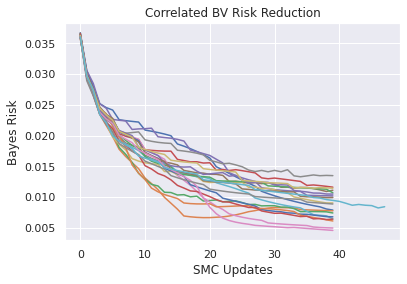

In [80]:
[plt.plot(result['risk']) for result in results] 
plt.xlabel("SMC Updates")
plt.ylabel("Bayes Risk")
plt.title("Correlated BV Risk Reduction")
#plt.savefig('figs/bayes_risk_rb_melbourne.pdf')

In [41]:
circuit.draw()

┌───┐      ░            ░ ┌───┐
q_0: ┤ H ├──────░───■────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_1: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_2: ┤ H ├──────░───┼────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_3: ┤ H ├──────░───┼────■───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘
q_4: ┤ H ├┤ Z ├─░─┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘ ░      
c: 4/═══════════════════════════════

In [236]:
# SIM for even numbers of measured qubits 
def sim(circuit, probs, n_shots=40):
    n_qubits = 4

    sim_strs = [
        [0] * n_qubits, 
        [1] * n_qubits,
        [0, 1] * (n_qubits // 2), 
        [1,0] * (n_qubits // 2)
    ]

    sim_results = {}
    for inversion_arr in sim_strs:

        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)


        job = execute(tmp_circuit, backend, shots=n_shots // 4)

        result = job.result()

        noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)

        noisy_counts = sample_distribution(noisy_measurement, n_shots // 4)

        for count in noisy_counts:
            count_arr = ''.join(map(str, [i ^ j for i, j in zip(inversion_arr, map(int, list(count[::-1])))]))

            if count_arr in sim_results:
                sim_results[count_arr] += noisy_counts[count]
            else:
                sim_results[count_arr] = noisy_counts[count]



    return sim_results


In [237]:
print('SIM', max(sim_results.values()) / sum(list(sim_results.values())))

SIM 0.7


In [266]:
# SIM for even numbers of measured qubits 
n_qubits = 4

def aim(circuit, probs, n_shots=40, confirmation_shots=1000):

    aim_strs = [[0] * n_qubits for _ in range(n_qubits)]

    for i in range(len(aim_strs)):
        aim_strs[i][i] = 1


    aim_results = {}
    for inversion_arr in aim_strs:

        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)


        job = execute(tmp_circuit, backend, shots=n_shots // len(aim_strs))

        result = job.result()

        noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)

        noisy_counts = sample_distribution(noisy_measurement, n_shots // len(aim_strs))

        aim_result = {}
        for count in noisy_counts:
            count_arr = ''.join(map(str, [i ^ j for i, j in zip(inversion_arr, map(int, list(count[::-1])))]))

            if count_arr in aim_result:
                aim_result[count_arr] += noisy_counts[count]
            else:
                aim_result[count_arr] = noisy_counts[count]

        aim_results[''.join(map(str, inversion_arr))] = aim_result
    
    # Find max aim
    max_inv_arr = max([(max([b for b in aim_results[i].values()]), i) for i in  aim_results])[1]

    # Run confirmation shots for statistics
    tmp_circuit = copy.deepcopy(circuit)
    tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)

    job = execute(tmp_circuit, backend, shots=confirmation_shots)

    result = job.result()

    noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)

    noisy_counts = sample_distribution(noisy_measurement, confirmation_shots)
    
    return noisy_counts
        

In [267]:
aim(circuit, probs)

{'0000': 11,
 '0001': 77,
 '0010': 71,
 '0011': 30,
 '0100': 68,
 '0101': 38,
 '0110': 40,
 '0111': 573,
 '1000': 0,
 '1001': 26,
 '1010': 27,
 '1011': 0,
 '1100': 39,
 '1101': 0,
 '1110': 0,
 '1111': 0}

(539, '0010')

In [127]:
print('AIM', max(aim_results.values()) / sum(list(aim_results.values())))

AIM 0.255


In [275]:
def ibmq_filter(circuit, probs, n_shots=1000):


    qr = QuantumRegister(4)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

    t_qc = transpile(meas_calibs, backend)
    qobj = assemble(t_qc, shots=n_shots)
    cal_results = backend.run(qobj, shots=n_shots).result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

    job = execute(circuit, backend, shots=1000)
    result = job.result()
    noisy_measurement = measurement_error(result.get_counts(circuit), n_qubits=n_qubits, probs=probs)
    noisy_counts = sample_distribution(noisy_measurement, n_shots)

    qiskit_results = meas_fitter.filter.apply(noisy_counts)
    return qiskit_results

In [139]:
ibmq_filter(circuit)

{'0000': 292.0000749351269,
 '0001': 21.99995559855539,
 '0010': 14.999970014496174,
 '0011': 91.9998982432742,
 '0100': 15.999967979507543,
 '0101': 115.99991944067031,
 '0110': 109.9999141017012,
 '0111': 2.7651354544807206e-05,
 '1000': 10.00042187997745,
 '1001': 95.9999016887447,
 '1010': 103.9999088297105,
 '1011': 2.760648151598627e-05,
 '1100': 126.99992913036134,
 '1101': 2.763097667978073e-05,
 '1110': 2.765141609030724e-05,
 '1111': 2.7617645375731335e-05}

In [301]:
probs = gen_error_probs(
        [100,0,10,0,0], # Const - Controls correlation of error weights
        [0, 5, 30, 5, 5], # 1 -> 0 - Controls error biases
        [0,-20,-20,-20,-20] # 0 -> 1 - Controls error biases
        )

for line in probs:
    for val in line:
        print("%.2f " % val, end='')
    print()

0.26 0.01 0.01 0.10 0.01 0.10 0.10 0.01 0.01 0.10 0.10 0.01 0.10 0.01 0.01 0.01 
0.00 0.37 0.00 0.02 0.00 0.02 0.04 0.15 0.00 0.02 0.04 0.15 0.04 0.15 0.00 0.02 
0.00 0.00 0.37 0.02 0.00 0.04 0.02 0.15 0.00 0.04 0.02 0.15 0.04 0.00 0.15 0.02 
0.00 0.00 0.00 0.56 0.00 0.00 0.00 0.03 0.00 0.00 0.00 0.03 0.06 0.06 0.06 0.22 
0.00 0.00 0.00 0.04 0.37 0.02 0.02 0.15 0.00 0.04 0.04 0.00 0.02 0.15 0.15 0.02 
0.00 0.00 0.00 0.00 0.00 0.56 0.00 0.03 0.00 0.00 0.06 0.06 0.00 0.03 0.06 0.22 
0.00 0.00 0.00 0.00 0.00 0.00 0.56 0.03 0.00 0.06 0.00 0.06 0.00 0.06 0.03 0.22 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.05 
0.00 0.00 0.00 0.04 0.00 0.04 0.04 0.00 0.37 0.02 0.02 0.15 0.02 0.15 0.15 0.02 
0.00 0.00 0.00 0.00 0.00 0.00 0.06 0.06 0.00 0.56 0.00 0.03 0.00 0.03 0.06 0.22 
0.00 0.00 0.00 0.00 0.00 0.06 0.00 0.06 0.00 0.00 0.56 0.03 0.00 0.06 0.03 0.22 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.05 
0.00 0.00 0.00 0.06 0.00 0.0

In [309]:
n_qubits = 4
n_shots=40

aim_res = []
sim_res = []
smc_res = []
ibmq_res = []
for i in range(2 ** n_qubits):
    bv_string = bin(i)[2:].zfill(n_qubits)
    
    circuit = bv_circuit(bv_string, n_qubits + 1)
    
    aim_res.append(aim(circuit, probs=probs, n_shots=n_shots))
    sim_res.append(sim(circuit, probs=probs, n_shots=n_shots))
    smc_res.append(smc(circuit, probs=probs, n_measurements=n_shots))
    ibmq_res.append(ibmq_filter(circuit, probs, n_shots=n_shots))
    

sim_probs = [max(r.values()) / sum(list(r.values())) for r in sim_res]
aim_probs = [max(r.values()) / sum(list(r.values())) for r in aim_res]
smc_probs = [max(r.values()) / sum(list(r.values())) for r in smc_res]
ibmq_probs = [max(r.values()) / sum(list(r.values())) for r in ibmq_res]

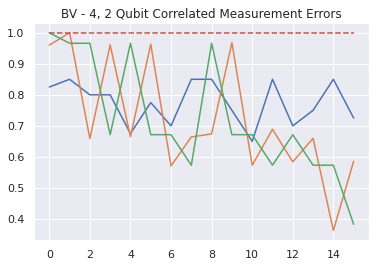

In [310]:
plt.title('BV - 4, 2 Qubit Correlated Measurement Errors')
plt.plot(sim_probs)
plt.plot(aim_probs)
plt.plot(smc_probs)
plt.plot(ibmq_probs, linestyle='--')

In [ ]:
plt.title('BV - 4, 2 Qubit Correlated Measurement Errors')
plt.plot(sim_probs, label='SIM')
plt.plot(aim_probs, label='AIM')
plt.plot(smc_probs, label='SMC')
plt.plot(ibmq_probs, linestyle='--', label='Qiskit')
plt.legend()